
-----------
Initializing structure...
time for choose_chunkdivision = 0.00340796 s
Working in 2D dimensions.
Computational cell is 60 x 30 x 0 with resolution 80
     block, center = (0,0,0)
          size (59.9875,37.4875,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (13.4473,-9.52625,0)
          size (60,0.5,1e+20)
          axes (0.948244,-0.317542,0), (0.317542,0.948244,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (13.7488,-8.57362,0)
          size (60,0.5,1e+20)
          axes (0.958293,-0.285787,0), (0.285787,0.958293,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (14.0159,-7.621,0)
          size (60,0.5,1e+20)
          axes (0.967195,-0.254033,0), (0.254033,0.967195,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (14.2495,-6.66837,0)
          size (60,0.5,1e+20)
          axes (0.974983,-0.222279,0), (0.222279,0.97498

KeyboardInterrupt: 

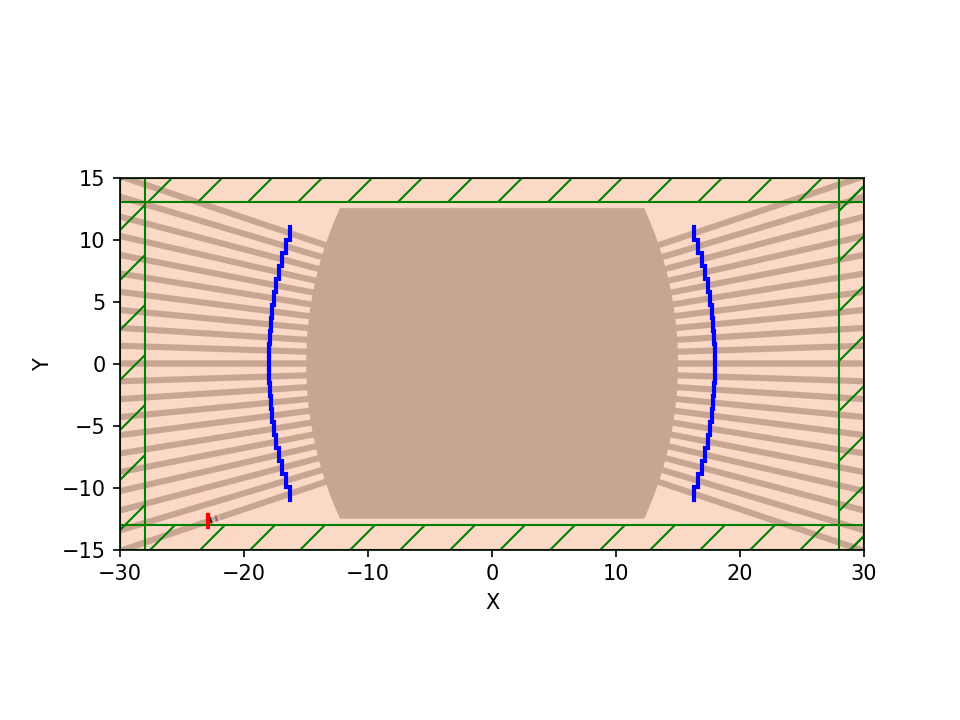

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages 
import meep as mp
#from meep.materials import SiO2, Si
%matplotlib widget

# To understand MEEP units see https://meep.readthedocs.io/en/latest/Introduction/#units-in-meep
wavelength = 1.55 # wavelength can have arbitrary length units (we choose um)
f = 1/wavelength # Frequency is defined in "natural units" as (1 um)/wavelength
l,w,z = [60,30,0] # length,width,height of the simulation region (um)
r = 30 # Star Coupler Radius (um)
h = 25 # Star Coupler Height (um) (this gives the flat top/bottom if desired)
waveguide_width = 0.5 # width of Si waveguide (um)
nguides_p = 10 # number of input waveguides above center (total numper is 2*nguides_p+1)
nangles = np.arange(-nguides_p,nguides_p+1,1) 
amplitudes = np.ones(len(nangles),dtype=complex) # amplitude/phase shift for each sources
## For tilted input
# amplitudes = np.zeros(len(nangles),dtype=complex) # amplitude/phase shift for each sources
# dl = 2*np.pi/len(nangles)
# for n in range(len(nangles)):
#     amplitudes[n]=np.exp(-1j*n)
y_guide_size = 1 # width of eigenmode source (needs to enclose waveguide)
dr = 10 # srces are placed at distance r+dr from confocal point
neff = 2.44 # Effective slab index from Lumerical simulation
#neff = 2.85
res = 80 # sim resolution (pixels/um)
# Define Simulation Cell
# All length units are microns
cell = mp.Vector3(l,w,z)
# Medium definition
si = mp.Medium(epsilon=12)
sio2 = mp.Medium(index=1.444)
rot_angles = [np.arcsin(i*np.sqrt((1.55)/(r*len(nangles)*neff))) for i in nangles]

sim = None

def create_star_block():
    # CREATE STAR COUPLER REGION AS MP MATERIAL GRID
    x = np.arange(-r,r,1/res)
    y = np.arange(-1.5*h/2,1.5*h/2,1/res)
    xx,yy = np.meshgrid(x,y)


    c1 = ((xx-r/2)**2 + yy**2 < r**2) # First circle with radius r
    c2 = ((xx+r/2)**2 + yy**2 < r**2) # Second circle with radius r
    b = (yy<h/2) & (yy>-h/2) # Rectangle allowing top/bottom cutoff

    sc = c1 & c2 & b # star coupler shape comes from logical-AND all 3 shapes

    star_grid = mp.MaterialGrid([len(x),len(y),0],
                            medium1 = sio2,
                            medium2 = si,
                            weights = sc.transpose())

    star_block = mp.Block(size=mp.Vector3(x[-1]-x[0],y[-1]-y[0],0),material=star_grid)
    return star_block

#INPUT AND OUTPUT WAVEGUIDES

def make_waveguide(th,l,r):
    wg = mp.Block(mp.Vector3(np.abs(l),waveguide_width,mp.inf),
                     center=mp.Vector3(0,0),
                     e1=mp.Vector3(x=1).rotate(mp.Vector3(z=1), th),
                     e2=mp.Vector3(y=1).rotate(mp.Vector3(z=1), th),
                     material=si)
    
    wg = wg.shift(mp.Vector3(x=r/2-l*np.cos(th)/2,y=-l*np.sin(th)/2))
    return wg

def create_input_waveguides():
    input_waveguides = [make_waveguide(th,l,r) for th in rot_angles]
    return input_waveguides

def create_output_waveguides():
    output_waveguides = [make_waveguide(th,-l,-r) for th in rot_angles]
    return output_waveguides

# ADD SOURCES
def wg_eig_src_guassian(r,dr,th,ysize=1,freq=f,bd=1,amp=1.0):
    k_point = mp.Vector3(1).rotate(mp.Vector3(z=1), -th)

    eig_src = mp.EigenModeSource(
        src=mp.GaussianSource(freq,fwidth=0.2*freq, width=2),
        size=mp.Vector3(y=ysize),
        direction=mp.NO_DIRECTION,
        eig_kpoint=k_point,
        center=mp.Vector3(-(r+dr)*np.cos(th)+r/2,(r+dr)*np.sin(th),0),
        eig_band = bd,
        eig_parity=mp.ODD_Z,
        eig_match_freq=True,
        amplitude=amp
        )
    return eig_src

def create_source_num(i):
    sources = [wg_eig_src_guassian(r,dr,rot_angles[i],ysize=y_guide_size,amp=amplitudes[i])]
    return sources

# Adds an eigenmode source for each input waveguide -- can get a source's amplitude to 0 to turn it off
# bottom 1/2
# sources = [wg_eig_src(r,dr,s,ysize=y_guide_size,amp=a) for (s,a) in zip(rot_angles[0:int((len(rot_angles)-1)/2)],amplitudes[0:int((len(rot_angles)-1)/2)])]

# full
# sources = [wg_eig_src_guassian(r,6,s,ysize=y_guide_size,amp=a) for (s,a) in zip(rot_angles,amplitudes)]

# #just 8 and 12
# # sources = [wg_eig_src_guassian(r,dr,rot_angles[7],ysize=y_guide_size,amp=amplitudes[7]), wg_eig_src_guassian(r,dr,rot_angles[11],ysize=y_guide_size,amp=amplitudes[11])]


 # ADD MONITORS
def create_monitor(r,dr,th,ysize=1):
    flux = sim.add_mode_monitor(f, 0, 1, 
                            mp.ModeRegion(mp.Vector3(-(r+dr)*np.cos(th)+r/2,(r+dr)*np.sin(th),0),size=mp.Vector3(y=ysize)), 
                            decimation_factor=0,
                            direction=mp.NO_DIRECTION
                            # eig_kpoint=mp.Vector3(x=1).rotate(mp.Vector3(z=1),-th)
                            )
    return flux

def create_output_monitors():
    output_monitors = [create_monitor(-r,-3,s,ysize=y_guide_size) for (s,a) in zip(rot_angles,amplitudes)]
    return output_monitors

def create_input_monitors():
    input_monitors = [create_monitor(r,3,s,ysize=y_guide_size) for (s,a) in zip(rot_angles,amplitudes)]
    return input_monitors

def create_pdf_output(input_monitors, output_monitors, iteration):
    # MAKE GRAPHS AND PDF
    figure,axes = plt.subplots()

    fig1 = sim.plot2D(ax=axes,output_plane=mp.Volume(center=mp.Vector3(), size=mp.Vector3(l,w,0)),
                fields=mp.Ez,
                field_parameters={'alpha':0.9})

    waveguides = []
    for i in range(len(input_monitors)):
        waveguides.append(str(i))

    input_flux = []
    output_flux = []

    total_input = 0
    total_output = 0

    for i in range(len(input_monitors)):
        input_flux.append(mp.get_fluxes(input_monitors[i])[0])
        total_input += mp.get_fluxes(input_monitors[i])[0]

        output_flux.append(mp.get_fluxes(output_monitors[i])[0])
        total_output += mp.get_fluxes(output_monitors[i])[0]

    # Make a data definition
    data_input = {'Input': input_flux}
    df_input = pd.DataFrame(data_input,columns=['Input'], index = waveguides)

    # Multiple bar chart
    fig2 = df_input.plot.bar()
    plt.title('Input Waveguide Flux Level')
    plt.xlabel('Waveguide')
    plt.ylabel('Flux')


    # Make a data definition
    data_output = {'Output': output_flux}
    df_output = pd.DataFrame(data_output,columns=['Output'], index = waveguides)

    # Multiple bar chart
    fig3 = df_output.plot.bar()
    plt.title('Output Waveguide Flux Level')
    plt.xlabel('Waveguide')
    plt.ylabel('Flux')

    # Make a data definition
    data_comparison = {
        'Input': input_flux,
        'Output': output_flux
        }
    df_comparison = pd.DataFrame(data_comparison,columns=['Input','Output'], index = waveguides)

    # Multiple bar chart
    fig4 = df_comparison.plot.bar()
    plt.title("Input Flux vs Ouput Flux for Simple Star Coupler")
    plt.xlabel("Wave Guide Number")
    plt.ylabel("Flux")

    p = PdfPages("Simple_Star_Coupler_SM_GRAPHS_" + str(iteration) + ".pdf")
    figs = [fig1, fig2, fig3, fig4]

    fig1.set_title("Efficiency = " + (str)(100*(total_output/total_input)) + "%")
    for fig in figs:
        fig.figure.savefig(p, format='pdf')

    p.close()

def run_and_make_video():
        f = plt.figure(dpi=150)
        Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True) 
        sim.run(mp.at_every(0.5, Animate), until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt=mp.Vector3(x=5), decay_by=1e-2))
        filename = "Simple_Star_Coupler_SM_VIDEO_" + str(iteration) + ".mp4"
        fps = 10
        Animate.to_mp4(fps, filename)

def short_test_run():
        f = plt.figure(dpi=150)
        Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True) 
        sim.run(mp.at_every(0.5, Animate), until=25)
        filename = "Simple_Star_Coupler_SM_VIDEO_" + str(iteration) + ".mp4"
        fps = 10
        Animate.to_mp4(fps, filename)

def load_sim_from_dump(filename):
    sim = mp.Simulation(resolution = res,
                            cell_size = cell,
                            default_material=sio2,
                            geometry = [create_star_block()] + create_output_waveguides() + create_input_waveguides(),
                            sources=create_source_num(iteration),
                            boundary_layers=[mp.PML(2.0)],
                            symmetries=[])
    input_monitors = create_input_monitors();
    output_monitors = create_output_monitors();

    sim.load(filename)

    return (sim, input_monitors, output_monitors)



# MAIN LOOP
for iteration in range(len(rot_angles)):
    print("Iteration: ", iteration)

    if (iteration == 0): #PRIMARY SETUP LOOP, THIS ONE INVOLVES COMPUTING THE STRUCTURE DATA WHICH WILL BE RESUSED IN OTHER RUNS TO SAVE TIME
        # CREATE SIMULATION OBJECT
        sim = mp.Simulation(resolution = res,
                            cell_size = cell,
                            default_material=sio2,
                            geometry = [create_star_block()] + create_output_waveguides() + create_input_waveguides(),
                            sources=create_source_num(iteration),
                            boundary_layers=[mp.PML(2.0)],
                            symmetries=[])
        input_monitors = create_input_monitors();
        output_monitors = create_output_monitors();
        sim.init_sim()
        # run_and_make_video()
        short_test_run()
        create_pdf_output(input_monitors, output_monitors, iteration)
        sim.dump_structure("Simple_Star_Coupler_SM_STRUCTURE")
        sim.dump("Simple_Star_Coupler_SM_DATA_" + str(iteration))
    else:
        sim = mp.Simulation(resolution = res,
                    cell_size = cell,
                    default_material=sio2,
                    sources=create_source_num(iteration),
                    boundary_layers=[mp.PML(2.0)],
                    symmetries=[])
        sim.load_structure("Simple_Star_Coupler_SM_STRUCTURE")
        
        input_monitors = create_input_monitors();
        output_monitors = create_output_monitors();
        sim.init_sim()
        # run_and_make_video()
        short_test_run();
        create_pdf_output(input_monitors, output_monitors, iteration)
        sim.dump("Simple_Star_Coupler_SM_DATA_" + str(iteration))

    sim.reset_meep() #ensure the next experiment is started with a clean slate
    





